Dans ce script, nous allons tester différents modèles de type convolution Nelle pour examiner leur performance. Nous allons ensuite tester s'ils sont robustes lorsqu'on applique une rotation à l'image d'entrée.

In [1]:
import retinoto_py as fovea

args = fovea.Params()
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	 user laurentperrinet	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 1998 has been set.


Params(image_size=224, do_mask=True, num_epochs=1, n_train_stop=100, seed=1998, batch_size=64, num_workers=4, model_name='resnet50', do_scratch=False, lr=0.0001, delta1=0.05, delta2=0.001, weight_decay=0.0, shuffle=True, verbose=True)

# testing each network on the validation dataset

In [2]:
import torch
dataset = 'Imagenet_bbox'
dataset = 'Imagenet_full'
TRAIN_DATA_DIR = args.DATAROOT / dataset / 'train'
VAL_DATA_DIR = args.DATAROOT / dataset / 'val'


In [3]:
from retinoto_py import get_loader
train_loader, class_to_idx, idx_to_class = get_loader(args, TRAIN_DATA_DIR)
val_loader, class_to_idx, idx_to_class = get_loader(args, VAL_DATA_DIR)

In [4]:
# --- 3. Load the Pre-trained ResNet Model ---
from retinoto_py import load_model
model = load_model(args)
num_classes = len(val_loader.dataset.classes)
num_ftrs = model.fc.out_features
print(f'Model has {num_ftrs} output features to final FC layer for {num_classes} classes.')

Model has 1000 output features to final FC layer for 1000 classes.


..................................................
Training model resnet50, file= cached_data/20_model_name=resnet50_dataset=full_retrained.pth - image_size=224
Starting learning...


epoch=1/1:   0%|          | 0/20019 [00:00<?, ?it/s]

cached_data/20_model_name=resnet50_dataset=full_retrained.pth 	| Epoch 0, i_image 128 	| train= loss: 0.5097 	| acc : 0.4375 - val= loss : 1.4147 	| acc : 0.7889 	| time:325.0
Saving...cached_data/20_model_name=resnet50_dataset=full_retrained.pth
Training completed in 5m 25s



AttributeError: 'PosixPath' object has no attribute 'remove'

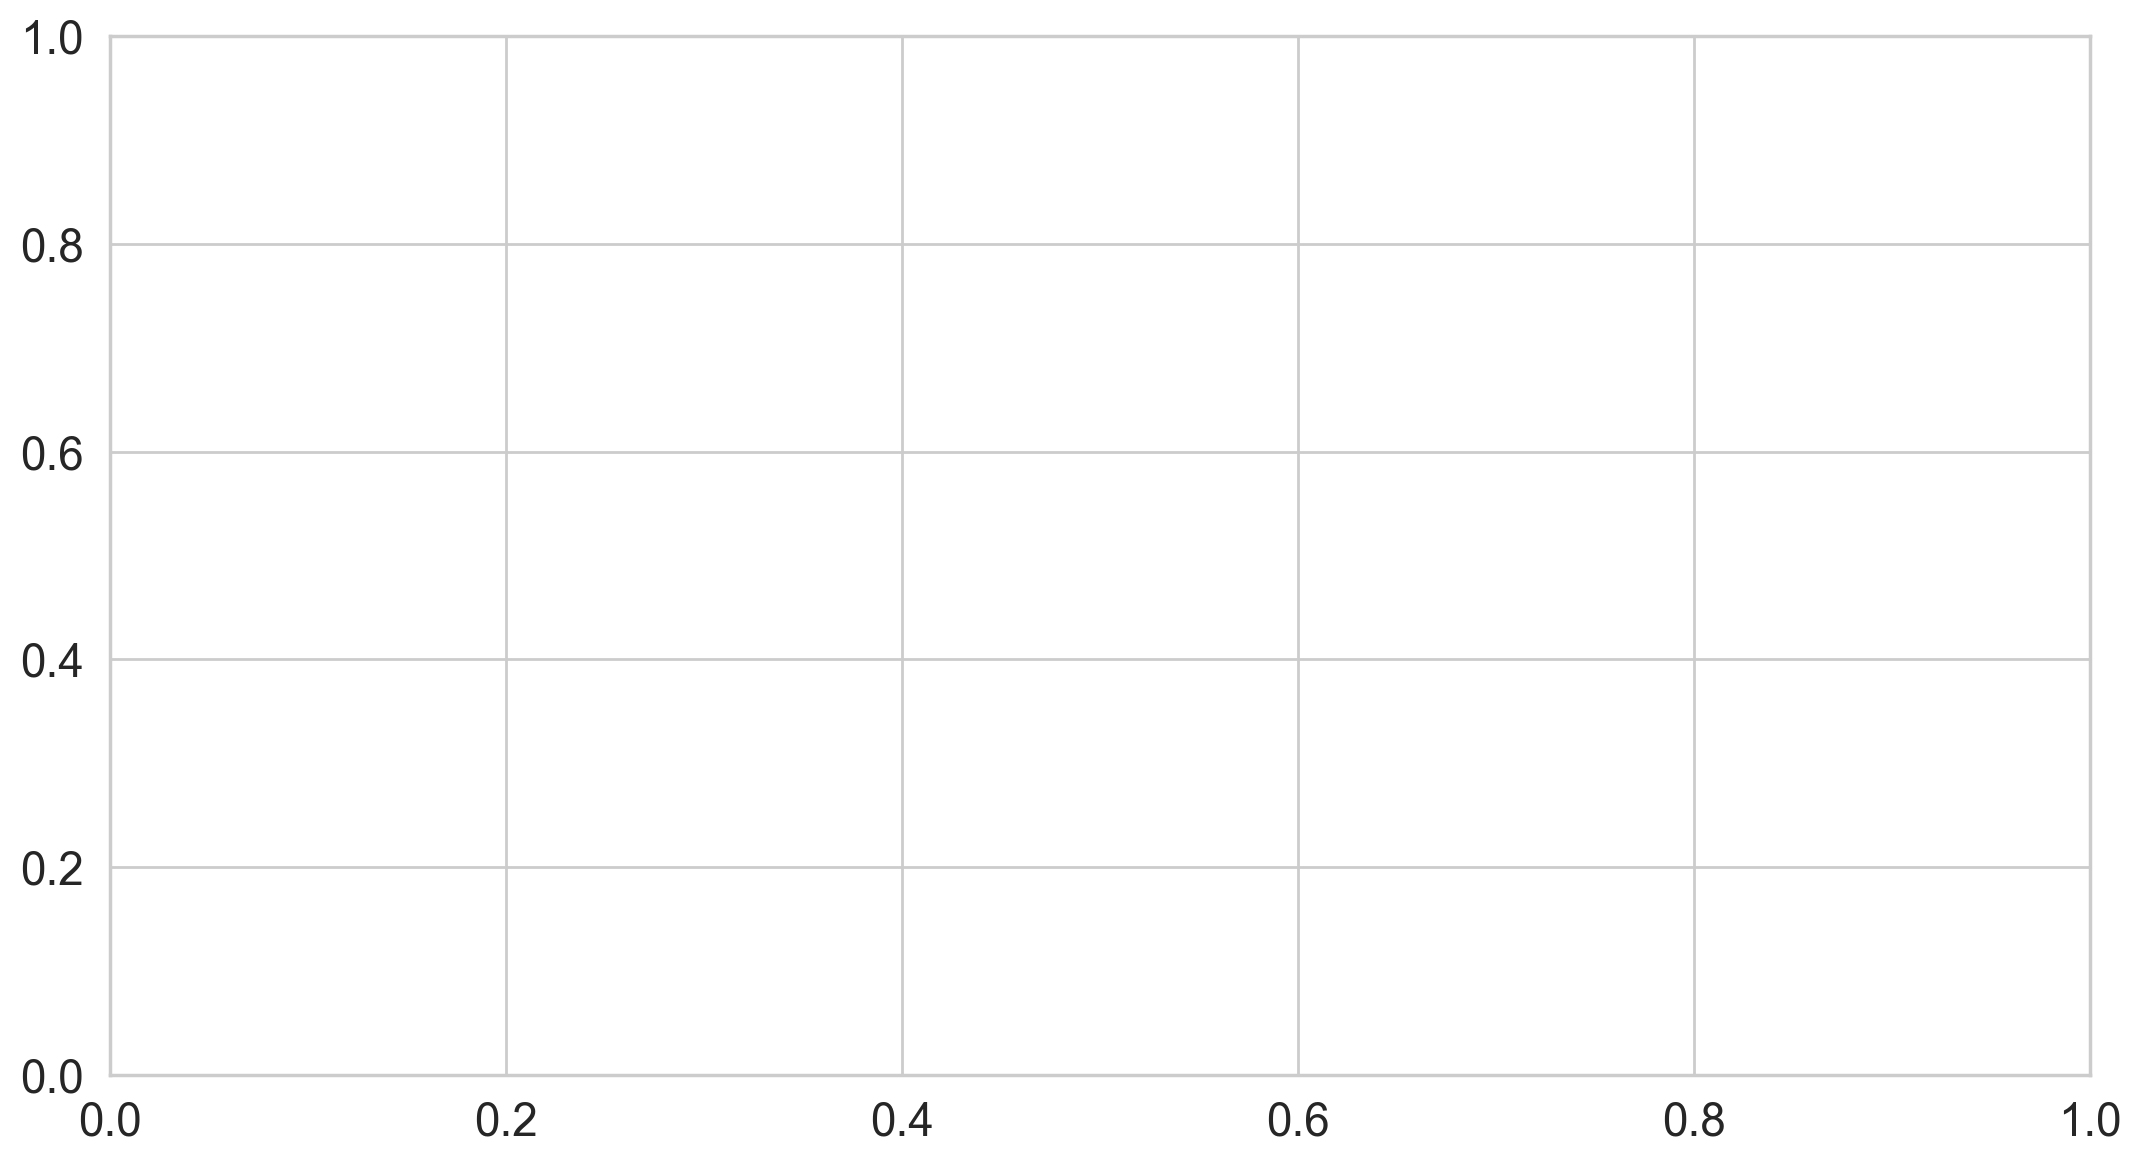

In [5]:
from pathlib import Path
import pandas as pd
import time 
from retinoto_py import train_model 
fig_width, phi = 12, 1.618
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi)) #, subplotpars=subplotpars)
model_name = args.model_name
for dataset in fovea.all_datasets:
    print(50*'.')
    model_filename = args.data_cache / f'20_model_name={model_name}_dataset={dataset}_retrained.pth'
    json_filename = args.data_cache / model_filename.name.replace('.pth', '.json')
    lock_filename = args.data_cache / model_filename.name.replace('.pth', '.lock')
    def touch(fname): open(fname, 'w').close()

    # %rm {lock_filename}

    df_train = None
    should_resume_training = not lock_filename.exists()

    if json_filename.exists():
        print(f"Load JSON from pre-trained resnet {json_filename}")
        df_train = pd.read_json(json_filename, orient='index')
        print(f"{model_filename}: accuracy = {df_train['avg_acc_val'][-5:].mean():.3f}")
        should_resume_training = (df_train['epoch'].max() + 1 < args.num_epochs) and (not lock_filename.exists())

    if should_resume_training:
        touch(lock_filename) # as we do a training let's lock it
        # we need to train the model or finish a training that already started
        print(f"Training model {args.model_name}, file= {model_filename} - image_size={args.image_size}")
        start_time = time.time()
        model_retrain, df_train = train_model(args, model=model, train_loader=train_loader, val_loader=val_loader, df_train=df_train, model_filename=model_filename, json_filename=json_filename)
        elapsed_time = time.time() - start_time
        print(f"Training completed in {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

        print()     

    color = 'r'
    lw = 1

    if not(df_train is None):
        trained_epochs = df_train['epoch'].max() + 1
        if trained_epochs < args.num_epochs:
            print(f"Training in progress with {trained_epochs} ")
        else:
            # the model has been trained, we can remove the lock file
            if lock_filename.exists(): lock_filename.remove()

            # x = df_train['total_image'].values
            # y = df_train['acc_val'].values

            df_train_roll = df_train.rolling(window=5, min_periods=1, center=False).mean()
            ax = df_train_roll.plot(x='total_image', y='acc_train', 
                                c=color, ls='dashed', lw=lw,
                                grid=True, ax=ax, label='TRAIN: ' + args.model_name)    
            ax = df_train_roll.plot(x='total_image', y='acc_val', 
                                c=color, lw=lw,
                                grid=True, ax=ax, label='VAL: ' + args.model_name)   



In [ ]:
lock_filename.exists()

In [ ]:
%rm {lock_filename}

In [ ]:
df_train.to_json(model_filename.name.replace('pth', 'json'), orient='records', indent=2)

In [ ]:
n_step = 12
for i_step in range(30):
    print(i_step % n_step, (i_step % n_step==0))
    